In [1]:
import pandas as pd
import numpy as np
import quadpy as qp
import scipy.stats as stats
import matplotlib.pyplot as plt

__Constant Elasticity of Variance Model (Cox, 1975)__

In order to benchmark the solution we obtain via quadrature, we start by implementing Monte Carlo pricing engine, exploiting the Fundamental Asset Pricing Formula:

$$
C_t = e^{-r(T-t)}\mathbf{E}^\mathbb{Q}[(S_T - K)^+ | S_t]
$$

In CEV framework, the dynamics of the stock price is given by the below SDE:

$$
dS_t = \mu S_t dt + \sigma S_t^{\beta/2} dW_t
$$
so that $\bar{\sigma} = \sigma S^{\left(1 - \frac{\beta}{2} \right)}_t$ is the local (instantaneous) volatility of the process. In order to capture leverage effect, i.e. the inverse relationship between spot price and volatility, we need to set $\beta < 2$. The above equation describes the dynamics of the stock price under physical probability measure $\mathbb{P}$, while options are priced under risk-neutral measure $\mathbb{Q}$. In order to make a transition between the measures, we simply replace real world drift $\mu$ with risk-free interest rate $r.$

In order to sample the process, we discretize the above equation using Euler scheme:

$$ 
S_{i+1} = S_i + \mu S_i \Delta t + \bar{\sigma}_i S_i \sqrt{\Delta t} \phi_i
$$

where $\phi_i \sim i.i.d. N(0,1)$. Because there is no closed form solution to CEV SDE, we need to obtain a vector of $S_T$ pathwise and can't resort to direct simulation as it would amplify the discretization error.

In [73]:
def cev(mu, sigma, beta, S0=100, T=1, Nsim=20000, steps=20):
    '''
    Produces path-wise simulation of CEV process to obtain a vector of stock prices at terminal time T
    '''
    dt = T/steps

    columns = np.linspace(0, steps, steps + 1)
    paths = pd.DataFrame(columns=columns)
    paths.iloc[:, 0] = [S0] * Nsim

    for i in range(1, steps + 1):
        st_norm = np.random.normal(0, 1, Nsim)
        paths.iloc[:, i] = [paths.iloc[n, i-1] + mu*paths.iloc[n, i-1]*dt + sigma*paths.iloc[n, i-1]**(1-0.5*beta)
                            * paths.iloc[n, i-1]*np.sqrt(dt)*st_norm[n] for n in range(Nsim)]

    ST = paths.iloc[:, -1]

    return ST

In [74]:
def mc_call(ST, K, r, T = 1, Nsim = 20000, significance_level = 0.05):
    '''
    Calculates the price of a European call option for a given simulation of stock prices at terminal time T
    '''
    price = np.exp(-r*T) * np.mean([max(S - K, 0) for S in ST])
    
    st_dev = np.std(ST)
    z_score = stats.norm.ppf(1 - significance_level/2) # 95% confidence interval
    error = z_score * st_dev / np.sqrt(Nsim)
    
    return price, error

In [75]:
# Test that the functions above execute the code 
test_simulation = cev(mu = 0.02, sigma = 0.1, beta = 1.9)
test_price, test_error = mc_call(test_simulation, K = 102, r = 0.02) # note r and mu must coincide to simulate under Q

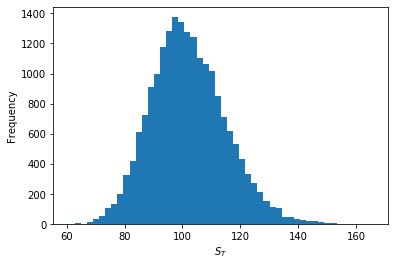

In [76]:
test_simulation.plot.hist(bins = 50);
plt.xlabel('$S_T$');

In [77]:
test_price, test_error

(5.049368872986278, 0.17911980799011387)

The price of a European call option in CEV framework can be expressed as:

$$
C_t(x, t) = e^x P_1(x, t) - K e^{-r(T-t)} P_2(x,t)
$$

The first term in this equation is the present value of the asset price and the second term is the present value of the strike-price payment, both conditional on optimal exercise but under different probability measures. $P_1$ is computed with the stock as numeraire asset, whereas $P_2$ is computed with a zero coupon bond as underlying numeraire asset. Since both $P_1$ and $P_2$ represent probability measures, we can write them in terms of their characteristic functions, i.e. Fourier transforms:

$$
P_k(x,t) = P_k (x_{\tau=0} \geq \ln{K} \text{ | } x_{\tau}) = \frac{1}{2} + \frac{1}{\pi} \int_0^{\infty} \mathbf{Re} \left[ \frac{e^{-i\varphi \ln{K}}}{i \varphi} \tilde{f}_k(x_{T, \varphi}|x_t) \right] d\varphi
$$

for $x = \ln{S}$, $\tau = T-t$ and $\tilde{f}_k(x_{\tau=0}, \varphi|x_{\tau}) = e^{C^k_{\tau}+i \varphi x_{\tau}}$ where:

$$
C^{1,2}_{\tau} = ri \varphi \tau \pm \frac{1}{2}\sigma^2 \varphi[i \mp \varphi e^{x(\beta -2)}]\tau
$$

In [2]:
def fk(x, beta, sigma, r, T, S, k):
    '''
    Calculates characteristic function of x = ln S
    '''
    if k == 1:
        C = r*1j*x*T + 0.5*sigma**2*x*(1j - x*np.exp(np.log(S)*(beta-2)))*T
    elif k == 2:
        C = r*1j*x*T - 0.5*sigma**2*x*(1j + x*np.exp(np.log(S)*(beta-2)))*T
    else:
        raise ValueError('k can only equal to 1 or 2')

    fk = np.exp(C + 1j*x*np.log(S))
    
    return fk

In [3]:
vfk = np.vectorize(fk)

In [4]:
def integrand(x, beta, sigma, r, T, S, K, k):
    
    weight = np.exp(-1j*x*np.log(K))/(1j*x)
    if k == 1:
        integrand = np.real(weight * vfk(x, beta, sigma, r, T, S, k))
    elif k == 2:
        integrand = np.real(weight * vfk(x, beta, sigma, r, T, S, k))
    else:
        raise ValueError('k can only equal to 1 or 2')
    
    return integrand

In [5]:
vintegrand = np.vectorize(integrand)

In [6]:
from scipy.integrate import quad

In [7]:
def ft_call(beta, sigma, r, T = 1, S0 = 100, K = 100):
    '''
    Calculates the price of a European call under CEV framework via FT
    '''
    int1, err1 = quad(lambda x: integrand(x, beta, sigma, r, T, S0, K, k = 1), 0, np.inf)
    int2, err2 = quad(lambda x: integrand(x, beta, sigma, r, T, S0, K, k = 2), 0, np.inf)
    
    P1 = 0.5 + (1/np.pi) * int1 
    P2 = 0.5 + (1/np.pi) * int2

    ft_call = S0*P1 - K*np.exp(-r*T)*P2
    
    return ft_call

In [8]:
ft_call(beta = 1.9, sigma = 0.1, r = 0.02, T = 1, S0 = 100, K = 102) # compare to MC estimate above

5.028447521700421

In [9]:
ft_call(beta = 2, sigma = 0.1, r = 0.02, T = 1, S0 = 100, K = 102) # compare to BS price below

3.997243090381346

Our Monte Carlo estimate, albeit being much more noisy, does show that our use of characteristic function to solve for the price of a European call in CEV framework was correct. Below we also implement standard Black-Scholes pricing formula in order to cross-check that for $\beta = 2$ both pricing engines reproduce the correct price.  

\begin{align}
C &= S N(d_1) - K e^{-rT} N(d_2) \\
d_1 &= \frac{\ln{\frac{S}{K}}+(r+\frac{\sigma^2}{2})T}{\sigma \sqrt{T}} \\
d_2 &= d_1 - \sigma \sqrt{T}
\end{align}

In [107]:
def bs_call(S, K, r, T, sigma):
    
    d1 = (np.log(S/K)+(r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    Nd1 = stats.norm.cdf(d1)
    Nd2 = stats.norm.cdf(d2)
    
    price = S*Nd1 - K*np.exp(-r*T)*Nd2
    
    return price

In [108]:
bs_call(S = 100, K = 102, r = 0.02, T = 1, sigma = 0.1)

3.9972430903813176

We start by calculating option sensitivities numerically, using finite differences. We choose central difference for delta, the rate of change of the option price with respect to the price of the underlying asset, because of its higher accuracy:

$$
\Delta = \frac{\partial C}{\partial S} \approx \frac{C(S+\delta S) - C(S- \delta S)}{2\delta S}
$$

One way of estimating gamma is to estimate delta using a forward difference, then estimate delta using a backward difference and then use the difference between these two estimates (divided by the distance between nodes) as the estimate of gamma:

$$
\Gamma = \frac{\partial^2 C}{\partial S^2} \approx \frac{C(S+\delta S) - 2 C(S) + C(S- \delta S)}{\delta S^2}
$$

We then use forward differences to estimate option's theta, vega and rho. In order to maintain their commonly accepted interpretation, we scale them appropriately in the function below. For example, theta is usually quoted as the change in the portfolio value when 1 calendar day passes with all else remaining the same.

$$
\Theta = \frac{\partial C}{\partial t} \approx \frac{C(t+\delta t) - C(t)}{\delta t}
$$

$$
\nu = \frac{\partial C}{\partial \sigma} \approx \frac{C(\sigma +\delta \sigma) - C(\sigma)}{\delta \sigma}
$$

$$
\rho = \frac{\partial C}{\partial r} \approx \frac{C(r+\delta r) - C(r)}{\delta r}
$$

In [105]:
def cev_sensitivities(beta, sigma, r, T = 1, S0 = 100, K = 100):
    
    c0 = ft_call(beta, sigma, r, T, S0, K)
    dS = S0*0.01
    dt = 1/365 # passage of one day
    dv = 0.01 # one "unit of volatility"
    dr = 0.01 # one percent change in rates
    
    delta = (ft_call(beta, sigma, r, T, S0+dS, K) - ft_call(beta, sigma, r, T, S0-dS, K))/(2*dS)
    gamma = (ft_call(beta, sigma, r, T, S0+dS, K) - 2*c0 + ft_call(beta, sigma, r, T, S0-dS, K))/dS**2
    theta = ft_call(beta, sigma, r, T-dt, S0, K) - c0
    vega = ft_call(beta, sigma+dv, r, T, S0, K) - c0
    rho = ft_call(beta, sigma, r+dr, T, S0, K) - c0
    
    print('Delta : ', round(delta, 4), '\nGamma : ', round(gamma, 4), 
          '\nTheta : ', round(theta, 4), '\nVega : ', round(vega, 4), '\nRho : ', round(rho, 4))
    
    return delta, gamma, theta, vega, rho

In [106]:
cev_sensitivities(beta = 2, sigma = 0.1, r = 0.02, T = 1, S0 = 100, K = 102);

Delta :  0.5206 
Gamma :  0.0398 
Theta :  -0.0081 
Vega :  0.3984 
Rho :  0.4982


__Merton Jump-Diffusion Model (1976)__

The risk-neutral stock price dynamics in Merton Jump-Diffusion model is given by the below SDE:

$$
dS_t = (r - r_J)S_t dt + \sigma S_t dW_t + J_t S_t dNt
$$

where $N_t$ is a Poisson process with intensity $\lambda$ and $J_t$ is the jump size at date $t$, that is distributed according to:

$$
log(1 + J_t) \sim N \left(log(1+\mu_J)-\frac{\delta^2}{2}, \delta^2 \right)
$$

and $r_J$, drift correction for jump, is defined as:

$$
r_J = \lambda (e^{\mu_J+\frac{\delta^2}{2}}-1)
$$

As with CEV, we start by valuing a European call using Monte Carlo simulation, for which we adopt the below discretization:

$$
S_{i+1} = S_i \left(e^{(r-r_J-\sigma^2/2)\Delta t + \sigma \sqrt{\Delta t} \phi^1_i}+(e^{\mu_J + \delta \phi^2_i}- 1) p_t \right)
$$

where $\phi_1$ and $\phi_2$ are independent sequences $\sim i.i.d. N(0,1)$ and $p_i \sim Poi(\lambda)$.

In [96]:
def m76(r, sigma, lamb, muj, delta, S0 = 100, T = 1, Nsim = 10000, steps = 50):
    '''
    Produces path-wise simulation of Merton jump-diffusion process to obtain a vector of stock prices at terminal time T
    '''
    rj = lamb * (np.exp(muj + 0.5 * delta**2) - 1)
    dt = T/steps
    
    columns = np.linspace(0, steps, steps + 1)
    paths = pd.DataFrame(columns = columns)
    paths.iloc[:, 0] = [S0] * Nsim
    
    for i in range(1, steps + 1):
        poi = np.random.poisson(lamb*dt, Nsim)
        phi1 = np.random.normal(0, 1, Nsim)
        phi2 = np.random.normal(0, 1, Nsim)
        paths.iloc[:, i] = [paths.iloc[n, i-1]*(np.exp((r-rj-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*phi1[n])
                                                +poi[n]*(np.exp(muj+delta*phi2[n])-1)) for n in range(Nsim)]
        
    ST = paths.iloc[:, -1]
    
    return ST

In [97]:
test_m76 = m76(r = 0.02, sigma = 0.1, lamb = 0.02, muj = -0.01, delta = 0.03, S0 = 100, T = 1, Nsim = 10000, steps = 50)
test_price_m76, test_error_m76 = mc_call(test_m76, K = 102, r = 0.02, T = 1, Nsim = 10000, significance_level = 0.05)
test_price_m76, test_error_m76

(3.977757431654554, 0.20129936089716885)

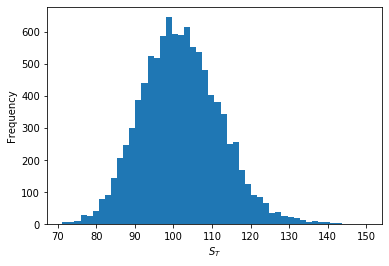

In [98]:
test_m76.plot.hist(bins = 50);
plt.xlabel('$S_T$');

Here we don't use Heston approach to representing a call option price in the traditional Black-Scholes-style formula. Instead, we implement the valuation formula derived by Lewis (2001):

$$
C_0 = S_0 - \frac{\sqrt{S_0 K}e^{-rT/2}}{\pi} \int_0^{\infty} \mathbf{Re} \left[e^{izk} \tilde{f}(z-i/2,T)\right] \frac{dz}{z^2+1/4}
$$

where $k = \log{K}$ and the corresponding characteristic function $\tilde{f}$ is:

$$
\tilde{f}(u,T) = \exp \left( \left( iu\omega - \frac{u^2\sigma^2}{2} + \lambda (e^{iu\mu_J-u^2\delta^2/2}-1) \right) T \right)
$$

where risk-neutral drift term $\omega = r-\frac{\sigma^2}{2}-\lambda(e^{\mu_J+\delta^2/2}-1)$.

In [99]:
def m76_char_func(u, T, r, sigma, lamb, mu, delta):
    omega = r - 0.5 * sigma ** 2 - lamb * (np.exp(mu + 0.5 * delta ** 2) - 1)
    value = np.exp((1j * u * omega - 0.5 * u ** 2 * sigma ** 2 + lamb * (np.exp(1j * u * mu - u ** 2 * delta ** 2 * 0.5) - 1)) * T)
    return value

In [100]:
def m76_integrand(u, S0, K, T, r, sigma, lamb, mu, delta):
    JDCF = m76_char_func(u - 0.5 * 1j, T, r, sigma, lamb, mu, delta) #jump-diffusion characteristic function
    value = 1 / (u ** 2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * JDCF).real
    return value

In [101]:
def m76_call(S0, K, T, r, sigma, lamb, mu, delta):
    int_value = qp.quad(lambda u: m76_integrand(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf)[0]
    call_value = S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value
    return call_value

In [102]:
m76_call(S0 = 100, K = 102, T = 1, r = 0.02, sigma = 0.1, lamb = 0.02, mu = -0.01, delta = 0.03)

4.001079708403651

In [103]:
def m76_sensitivities(S0, K, T, r, sigma, lamb, mu, delta):
    
    c0 = m76_call(S0, K, T, r, sigma, lamb, mu, delta)
    dS = S0*0.01
    dt = 1/365 # passage of one day
    dv = 0.01 # one "unit of volatility"
    dr = 0.01 # one percent change in rates
    
    dlta = (m76_call(S0+dS, K, T, r, sigma, lamb, mu, delta) - m76_call(S0-dS, K, T, r, sigma, lamb, mu, delta))/(2*dS)
    gamma = (m76_call(S0+dS, K, T, r, sigma, lamb, mu, delta) - 2*c0 + m76_call(S0-dS, K, T, r, sigma, lamb, mu, delta))/dS**2
    theta = m76_call(S0, K, T-dt, r, sigma, lamb, mu, delta) - c0
    vega = m76_call(S0, K, T, r, sigma+dv, lamb, mu, delta) - c0
    rho = m76_call(S0, K, T, r+dr, sigma, lamb, mu, delta) - c0
    
    print('Delta : ', round(dlta, 4), '\nGamma : ', round(gamma, 4), 
          '\nTheta : ', round(theta, 4), '\nVega : ', round(vega, 4), '\nRho : ', round(rho, 4))
    
    return dlta, gamma, theta, vega, rho

In [104]:
m76_sensitivities(S0 = 100, K = 102, T = 1, r = 0.02, sigma = 0.1, lamb = 0.02, mu = -0.01, delta = 0.03);

Delta :  0.5207 
Gamma :  0.0398 
Theta :  -0.0081 
Vega :  0.398 
Rho :  0.4982


__Model Calibration__

Now that we have working pricing functions for both models, we can calibrate them to observed market prices. We choose Root Mean Squared Error as our error function to be minimized:

$$
\min_{\bar{\theta}} \sqrt{\frac{1}{N} \sum_{n=1}^{N} \left(C^{market}_n - C^{model}_n (\bar{\theta}) \right)}
$$

where we denote a generic vector of model parameters as $\bar{\theta}$. We use free data sets available on Yahoo Finance in order to obtain market data. While CBOE traded options are American, since we are only calibrating call prices, the price difference (if any) shouldn't be material to affect the results of our analysis. Our choice of single-stock options on Amazon has the added benefit of not having to deal with dividends.

In [10]:
from yahoo_fin import options
from yahoo_fin import stock_info

In [23]:
stock_info.get_live_price('AMZN')

2764.409912109375

In [24]:
S0 = 2764.41
today = pd.Timestamp('2020-06-23')

In [25]:
exp_dates = options.get_expiration_dates('AMZN') #list of strings containing expiration dates 'Month DD, YYYY'

In [26]:
exp_dates

['June 26, 2020',
 'July 2, 2020',
 'July 10, 2020',
 'July 17, 2020',
 'July 24, 2020',
 'July 31, 2020',
 'August 21, 2020',
 'September 18, 2020',
 'October 16, 2020',
 'November 20, 2020',
 'January 15, 2021',
 'February 19, 2021',
 'June 18, 2021',
 'January 21, 2022']

In [292]:
amzn_chains = pd.DataFrame()

for i in range(5): #limiting dataset to short maturities 
    T = (pd.Timestamp(exp_dates[i]) - today) / np.timedelta64(1, 'Y') #time to maturity in years
    chain = options.get_calls('AMZN', exp_dates[i])[['Strike','Last Price']]
    chain['T'] = T
    amzn_chains = pd.concat([amzn_chains, chain])

amzn_chains = amzn_chains.reset_index(drop = True) #all call options on AMZN with expiry date < 1 month

In [293]:
#limiting dataset to near ATM strikes
amzn_chains = amzn_chains.loc[(amzn_chains['Strike'] < S0*1.1) & (amzn_chains['Strike'] > S0*0.9)] 
amzn_chains = amzn_chains.reset_index(drop = True)

In [294]:
amzn_chains['S0'] = S0
amzn_chains['r'] = 0.0014 #1 month US Treasury yield as of June 9, 2020

In [295]:
amzn_chains.head()

,Strike,Last Price,T,S0,r
0,2390.0,264.00,0.002738,2653.98,0.0014
1,2395.0,251.20,0.002738,2653.98,0.0014
2,2400.0,251.37,0.002738,2653.98,0.0014
3,2405.0,241.90,0.002738,2653.98,0.0014
4,2410.0,237.00,0.002738,2653.98,0.0014


We start by calibrating Merton Jump-Diffusion model. It is well established that the degrees of freedom in the model are not sufficient to simultaneously accommodate both the different maturities and the different strike levels. However, the model reproduces short-term option prices around at-the-money strike levels reasonably well and therefore we limit our dataset only to those options. 

We use some elements from Hilpisch (2015) to produce our calibration procedure. Here we use the “brute force” method, i.e. compute the error function’s value at each point of a multidimensional grid of points to find its global minimum.

In [27]:
import scipy.optimize as sop

In [ ]:
def m76_rmse(p0, dataset = amzn_chains):
    
    sigma, lamb, mu, delta = p0
    se = []
    for n in dataset.index:
        model_value = m76_call(dataset.loc[n, 'S0'], dataset.loc[n, 'Strike'], dataset.loc[n, 'T'], 
                               dataset.loc[n, 'r'], sigma, lamb, mu, delta)
        se.append((dataset.loc[n, 'Last Price'] - model_value) ** 2)
    RMSE = np.sqrt(sum(se) / len(se))
    
    return RMSE

In [298]:
p0 = sop.brute(m76_rmse, ((0.1, 0.5, 0.05), (0.0, 0.2, 0.05), (-0.1, 0.1, 0.05), (0.0, 0.3, 0.05)), finish = None)

In [299]:
p0

array([0.25, 0.15, 0.05, 0.25])

The above parameters make sense intuitively, except for a slightly lower than expected volatility of the stock. It is however compensated by larger than expected intensity of the Poisson process and the volatility of the jump size.

We then proceed to calibrating CEV model, for which we use the full range of maturities available in the market.

In [34]:
amzn_full = pd.DataFrame()

for i in np.arange(7, 10): #limiting dataset to short maturities 
    T = (pd.Timestamp(exp_dates[i]) - today) / np.timedelta64(1, 'Y') #time to maturity in years
    chain = options.get_calls('AMZN', exp_dates[i])[['Strike','Last Price']]
    chain['T'] = T
    amzn_full = pd.concat([amzn_full, chain])

amzn_full = amzn_full.loc[(amzn_full['Strike'] < S0*1.25) & (amzn_full['Strike'] > S0*0.75)] 
amzn_full = amzn_full.reset_index(drop = True)
amzn_full['S0'] = S0
amzn_full['r'] = 0.0014

In [35]:
amzn_full

,Strike,Last Price,T,S0,r
0,2075.0,620.37,0.238198,2764.41,0.0014
1,2080.0,583.85,0.238198,2764.41,0.0014
2,2085.0,492.04,0.238198,2764.41,0.0014
3,2090.0,669.60,0.238198,2764.41,0.0014
4,2095.0,366.81,0.238198,2764.41,0.0014
...,...,...,...,...,...
362,3000.0,148.00,0.410686,2764.41,0.0014
363,3100.0,113.63,0.410686,2764.41,0.0014
364,3200.0,90.80,0.410686,2764.41,0.0014
365,3300.0,71.35,0.410686,2764.41,0.0014


In [36]:
def cev_rmse(p0, dataset = amzn_full):
    
    beta, sigma = p0
    se = []
    for n in dataset.index:
        model_value = ft_call(beta, sigma, dataset.loc[n, 'r'], dataset.loc[n, 'T'], 
                              dataset.loc[n, 'S0'], dataset.loc[n, 'Strike'])
        se.append((dataset.loc[n, 'Last Price'] - model_value) ** 2)
    RMSE = np.sqrt(sum(se) / len(se))
    
    return RMSE

In [ ]:
p0_cev = sop.brute(cev_rmse, ((1., 2., 0.25), (0.0, 0.5, 0.125)), finish = None)

In [146]:
p0_cev

array([1.75 , 0.125])

__Selecting quadrature scheme__

The general quadrature formula is:

$$
\int_a^b f(x) dx \approx \sum_{i=0}^n a_i f(x_i)
$$

where 

$$
a_i = \int_a^b L_i(x) dx = \int_a^b \prod_{k = 0\\k \neq i}^n \frac{(x-x_k)}{(x_i-x_k)}
$$ 

is the intergral of the Lagrange polynomial of selected order. The error of this approximation is given by:

$$
\epsilon(f) = \frac{1}{(n+1)!} \int_a^b \prod_{i=0}^n (x-x_i) f^{(n+1)} (\xi(x)) dx
$$

where $\xi(x)$ is one of the nodes at which the Lagrange polynomial is evaluated. __Simpson's rule__, for example, mandates the use of second-order Lagrange polynomials and equally spaced nodes. Over large intervals the choice of equally-spaced nodes is however inaccurate because of the oscillatory nature of high-degree polynomials. In addition, the variation of the function on the interval of integration is important as smaller step size between the nodes is needed for the large-variation regions than for those with less variation.

Quadrature methods belonging to the family of Gaussian quadratures correct the above disadvantages by choosing the nodes for evaluation in an optimal, rather than equally-spaced, way. The nodes $\{x_1, x_2, ..., x_n\}$ and the weights $\{w_1, w_2, ... , w_n \}$ are chosen to minimize the expected error obtained in the approximation:

$$
\int_a^b f(x) dx \approx \sum_{i=1}^n w_i f(x_i)
$$

In general, it is required to generate orthogonal polynomials $\{ p_0, ... , p_n\}$, find their roots and compute the corresponding weights, according to appropriately chosen weighting function.

__Gauss-Laguerre quadrature__ is particularly well-suited to approximate the integrals of the functions of type:

$$
\int_0^{\infty} e^{-x} f(x) dx \approx \sum_{i=1}^n w_i f(x_i)
$$

The abscissas for quadrature of order $n$ are given by the roots of the Laguerre polynomials $L_n(x)$:

$$
L_n(x) = \sum_{k=0}^n \frac{(-1)^k}{k!} {n \choose k} x^k
$$

and the corresponding weights are given by:

$$
w_i = \frac{x_i}{(n+1)^2[L_{n+1}(x_i)]^2}
$$

__Gauss-Lobatto__ quadrature is Gaussian quadrature with weighting function $w(x)=1$ in which the endpoints of the interval $[-1,1]$ are included in a total of $n$ abscissas, giving $n-2$ free abscissas. Abscissas are symmetrical about the origin, and the general formula is

$$
\int_{-1}^{1} f(x) dx \approx w_1 f(-1) + w_n f(1) + \sum_{i=2}^{n-1} w_i f(x_i) 	
$$

The free abscissas $x_i$ for $i=2, ..., n-1$ are the roots of the polynomial $P_{n-1}^{'}(x)$, where $P(x)$ is a Legendre polynomial. The weights of the free abscissas are:

$$
w_i	= \frac{2}{n(n-1)[P_{n-1}(x_i)]^2}
$$

and of the endpoints are:

$$
w_{1,n}= \frac{2}{n(n-1)}
$$

In [ ]:
#Above quadratute schemes implemented in Quadpy package:
qp.e1r.gauss_laguerre(5, alpha = 0)
qp.line_segment.gauss_lobatto(5)
qp.line_segment.newton_cotes_closed(2)

We implement Gauss-Laguerre scheme below and demonstrate the nodes and the weights produced by the scheme. Suprisingly, the scheme underestimates both integrals by an order of magnitude, comparing to SciPy implementation that relies on Fortran library QUADPACK. Changing the number of nodes doesn't affect the scheme's performance. The problem seems to stem from the low weights assigned to the function values at the nodes, particularly comparing to Gauss-Lobatto scheme. 

In [136]:
scheme = qp.e1r.gauss_laguerre(20) #evaluated at 20 points

$$
\int_0^{\infty} e^{-x} f(x) dx \approx \sum_{i=1}^n w_i f(x_i)
$$

In [137]:
res1 = vintegrand(scheme.points, beta = 1.9, sigma = 0.1, r = 0.02, T = 1, S = 100, K = 102, k = 1) * scheme.weights * np.exp(scheme.points)
res1.sum()

0.08194717810527292

In [138]:
res2 = vintegrand(scheme.points, beta = 1.9, sigma = 0.1, r = 0.02, T = 1, S = 100, K = 102, k = 2) * scheme.weights * np.exp(scheme.points)
res2.sum()

-0.07573110387991731

In [139]:
int1/res1.sum()

0.9999999999980127

In [140]:
int2/res2.sum()

0.9999999999980095

In [141]:
P1 = 0.5 + (1/np.pi) * res1.sum()
P2 = 0.5 + (1/np.pi) * res2.sum()

call = 100*P1 - 102*np.exp(-0.02)*P2

In [142]:
call #compare to the below value (also obtained previously)

5.02844752171039

In [48]:
#original integration solved using SciPy quad. Compare int1 and int2 to res1 and res2.

int1, err1 = quad(lambda x: integrand(x, beta = 1.9, sigma = 0.1, r = 0.02, T = 1, S = 100, K = 102, k = 1), 0, np.inf)
int2, err2 = quad(lambda x: integrand(x, beta = 1.9, sigma = 0.1, r = 0.02, T = 1, S = 100, K = 102, k = 2), 0, np.inf)

In [49]:
int1

0.08194717810511007

In [50]:
int2

-0.07573110387976657

In [222]:
P1 = 0.5 + (1/np.pi) * int1
P2 = 0.5 + (1/np.pi) * int2

call = 100*P1 - 102*np.exp(-0.02)*P2

In [223]:
call

5.028447521700421

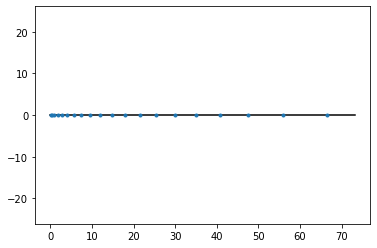

In [144]:
scheme.show()

In [79]:
scheme.points

array([ 0.26356032,  1.41340306,  3.59642577,  7.08581001, 12.64080084])

In [80]:
scheme.weights

array([5.21755611e-01, 3.98666811e-01, 7.59424497e-02, 3.61175868e-03,
       2.33699724e-05])

Gauss-Lobatto scheme, however, does produce the correct price with improved performance from both increasing the upper limit of integration and the number of nodes.

In [224]:
lobatto = qp.line_segment.gauss_lobatto(5)

In [238]:
int1 = lobatto.integrate(lambda x: integrand(x, beta = 1.9, sigma = 0.1, r = 0.02, T = 1, S = 100, K = 102, k = 1), [0.0001, 50])
int1

0.08204119551652056

In [239]:
int2 = lobatto.integrate(lambda x: integrand(x, beta = 1.9, sigma = 0.1, r = 0.02, T = 1, S = 100, K = 102, k = 2), [0.0001, 50])
int2

-0.07581784077089727

In [240]:
P1 = 0.5 + (1/np.pi) * int1
P2 = 0.5 + (1/np.pi) * int2

call = 100*P1 - 102*np.exp(-0.02)*P2

In [241]:
call

5.034200564970654

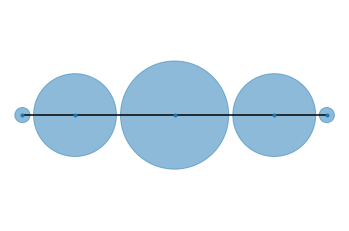

In [242]:
lobatto.show()

In [225]:
lobatto.points

array([-1.00000000e+00, -6.54653671e-01,  6.66133815e-16,  6.54653671e-01,
        1.00000000e+00])

In [226]:
lobatto.weights

array([0.1       , 0.54444444, 0.71111111, 0.54444444, 0.1       ])

In [257]:
def gl_cev_call(gl_params, beta, sigma, r, T = 1, S0 = 100, K = 102):
    
    nnodes, upplim = gl_params
    scheme = qp.line_segment.gauss_lobatto(nnodes)
    
    int1 = scheme.integrate(lambda x: vintegrand(x, beta, sigma, r, T, S0, K, k = 1), (0.001, upplim))
    int2 = scheme.integrate(lambda x: vintegrand(x, beta, sigma, r, T, S0, K, k = 2), (0.001, upplim))
    
    P1 = 0.5 + (1/np.pi) * int1 
    P2 = 0.5 + (1/np.pi) * int2

    ft_call = S0*P1 - K*np.exp(-r*T)*P2
    
    return ft_call

In [258]:
gl_cev_call((5, 50), 1.9, 0.1, 0.02)

5.0339144569799

In [270]:
nnodes = np.linspace(5, 105, 21)
upplim = np.linspace(15, 105, 21)

In [280]:
var_nod = [gl_cev_call((int(nnode), 50), 1.9, 0.1, 0.02) for nnode in nnodes]
var_lim = [gl_cev_call((50, limit), 1.9, 0.1, 0.02) for limit in upplim]

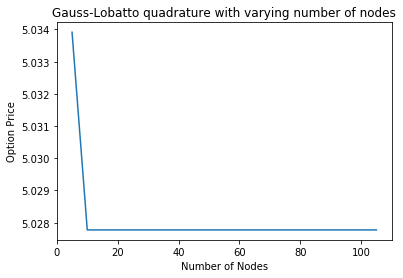

In [285]:
plt.plot(nnodes, var_nod);
plt.title('Gauss-Lobatto quadrature with varying number of nodes');
plt.xlabel('Number of Nodes');
plt.ylabel('Option Price');

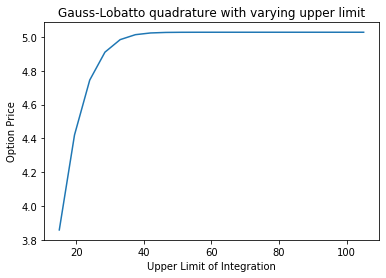

In [286]:
plt.plot(upplim, var_lim);
plt.title('Gauss-Lobatto quadrature with varying upper limit');
plt.xlabel('Upper Limit of Integration');
plt.ylabel('Option Price');